In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tff
import pandas as pd
import ROI
import scipy.ndimage as ndi

## Import tiff

In [29]:
fPath = '/Users/yungkuo/Google Drive/072116 beads for calibration/'
fName1 = 'pink 002-dot.tif'
fName2 = 'pink 002-prism.tif'

In [30]:
tiffimg = tff.TiffFile(fPath+fName1)
image_dot = tiffimg.asarray()
tiffimg = tff.TiffFile(fPath+fName2)
image_prism = tiffimg.asarray()

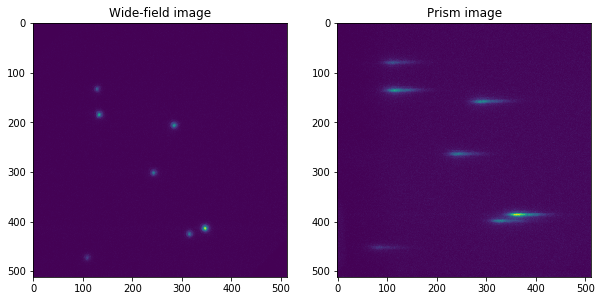

In [31]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image_dot)
ax[1].imshow(image_prism)
ax[0].set_title('Wide-field image')
ax[1].set_title('Prism image')

## Background correction

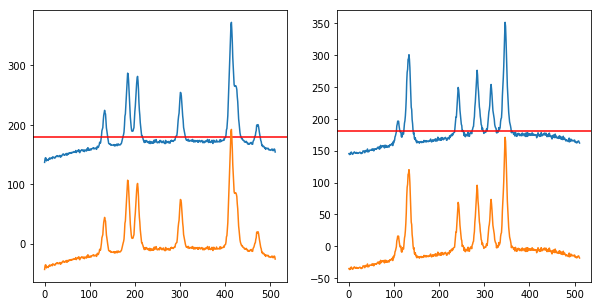

In [32]:
bgroi = (slice(200,300), slice(400,500))
image_dot_bgcr = image_dot - np.mean(image_dot[bgroi])
image_prism_bgcr = image_prism - np.mean(image_prism[bgroi])
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(image_dot.mean(1))
ax[0].axhline(y=image_dot[bgroi].mean(), color='r')
ax[0].plot(image_dot_bgcr.mean(1))
ax[1].plot(image_dot.mean(0))
ax[1].axhline(y=image_dot[bgroi].mean(), color='r')
ax[1].plot(image_dot_bgcr.mean(0))

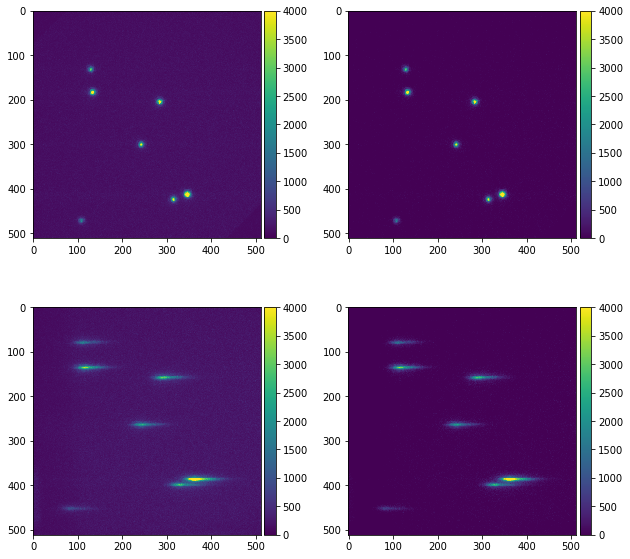

In [33]:
mask = np.zeros(image_dot.shape)
mask[bgroi] = 1
vmin, vmax = (0,4000)

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.ravel('F')
im = {}
im[0] = ax[0].imshow(image_dot, vmin=vmin, vmax=vmax)
im[1] = ax[1].imshow(image_prism, vmin=vmin, vmax=vmax)
#ax[0].imshow(mask, alpha=0.3, cmap='gray')
#ax[1].imshow(mask, alpha=0.3, cmap='gray')
im[2] = ax[2].imshow(image_dot_bgcr, vmin=vmin, vmax=vmax)
im[3] = ax[3].imshow(image_prism_bgcr, vmin=vmin, vmax=vmax)

from mpl_toolkits.axes_grid1 import make_axes_locatable
for i in range(4):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im[i], cax=cax)
    plt.subplots_adjust(wspace = 0.3) 

## Find dots' coordinates

In [34]:
scan = [3,3]
pts_dot = ROI.finddot(image_dot_bgcr, scan, nstd=1.4)

/Users/yungkuo/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yungkuo/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


In [35]:
pts_dot.shape

(7, 2)

### Exclude duplicates

In [36]:
index = []
for i in range(1, len(pts_dot)-1):
    if np.sum((pts_dot[i] - pts_dot[i+1])**2) >= np.sum(np.array(scan)**2):
        if np.sum((pts_dot[i] - pts_dot[i-1])**2) >= np.sum(np.array(scan)**2):
            index = np.append(index, i)
if np.sum((pts_dot[0] - pts_dot[1])**2) >= np.sum(np.array(scan)**2):
    index = np.append(index, 0)
if np.sum((pts_dot[len(pts_dot)-1] - pts_dot[len(pts_dot)-2])**2) >= np.sum(np.array(scan)**2):
    index = np.append(index, len(pts_dot)-1)  
index = np.unique(index).astype('int')
pts_dot = pts_dot[list(index)]

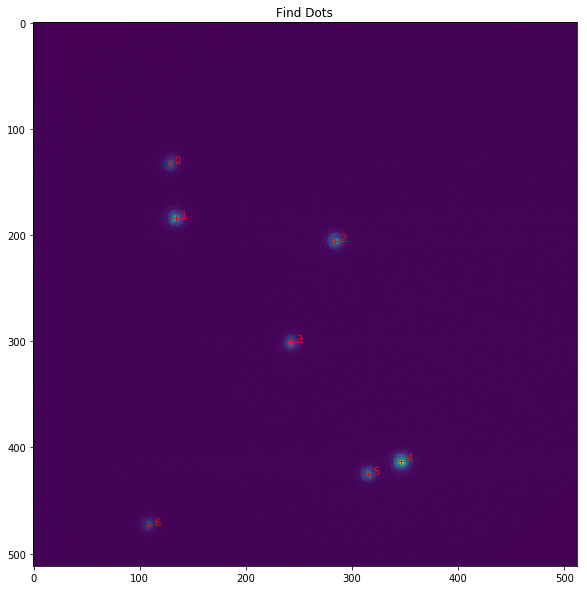

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Find Dots')
for count, pt in enumerate(pts_dot):
    ax.plot(pt[0],pt[1], 'r+')
    ax.annotate(count, xy=pt+[5,0], color='r')
ax.imshow(image_dot_bgcr, interpolation='None')

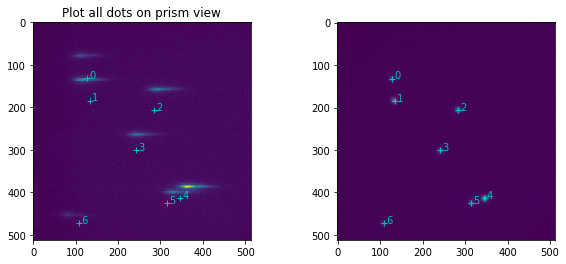

In [38]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].set_title('Plot all dots on prism view')
for count, pt in enumerate(pts_dot):
    ax[0].plot(pt[0],pt[1], 'c+')
    ax[0].annotate(count, xy=pt+[5,0], color='c')
    ax[1].plot(pt[0],pt[1], 'c+')
    ax[1].annotate(count, xy=pt+[5,0], color='c')
ax[0].set_ylim(512,0)
ax[0].set_xlim(0,512)
ax[1].imshow(image_dot_bgcr)
ax[0].imshow(image_prism_bgcr)

## Shift match coordinates

In [39]:
shift, mag = (-60.918637535924951, 0.90703524833602123)

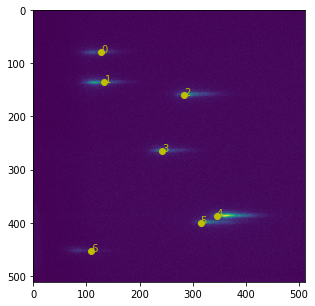

In [40]:
fig, ax = plt.subplots(figsize=(5,5))
for count, pt in enumerate(pts_dot):
    point = (pt[0], (pt[1]+shift)/mag)
    ax.plot(point[0], point[1], 'yo')
    ax.annotate(count, xy=point, color='y')
ax.imshow(image_prism_bgcr)

## Find local max in prism view near dot coordinate

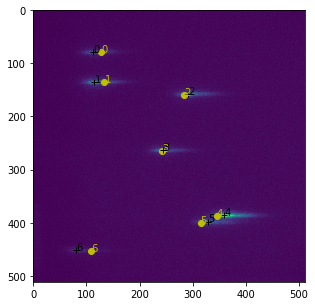

In [41]:
x_shift = -10
scan = [3,20]
points_prism = pd.DataFrame()
fig, ax = plt.subplots(figsize=(5,5))
for count, pt in enumerate(pts_dot):
    ax.plot(pt[0], (pt[1]+shift)/mag, 'yo')
    ax.annotate(count, xy=[pt[0],(pt[1]+shift)/mag], color='y')
    
    point = np.array((pt[0]-x_shift, (pt[1]+shift)/mag))
    if point[0] > scan[1]*3 and point[1] > scan[0]*2:
        if point[0] < 512-scan[1]*2 and point[1] < 512-scan[0]*2:
            point = ROI.get_local_max(image_prism_bgcr, point, scan)
            PP1 = pd.DataFrame({'x':point[0], 'y':point[1]}, index=[count])
            points_prism = points_prism.append(PP1)
            ax.plot(point[0], point[1], 'k+')
            ax.annotate(count, xy=point, color='k')
ax.imshow(image_prism_bgcr)

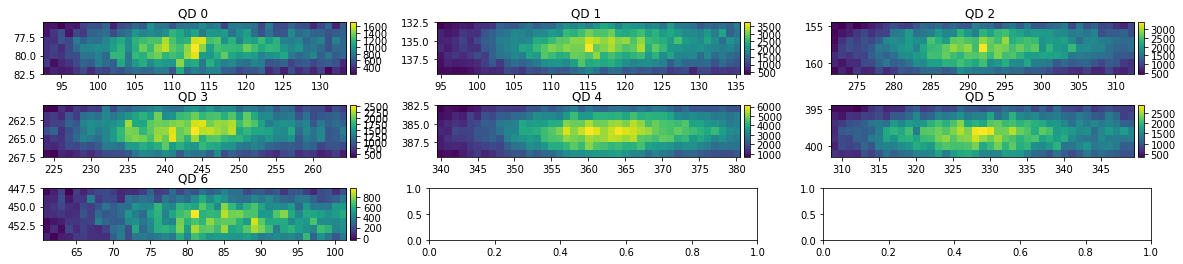

In [42]:
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(int(math.ceil(float(len(points_prism))/3)), 3, figsize=(20,math.ceil(float(len(points_prism))/2)))
ax = ax.ravel()
for count, noQD in enumerate(list(points_prism.index)):
    point = (points_prism.loc[noQD]['x'], points_prism.loc[noQD]['y'])
    roi = ROI.get_roi_square(point, scan)
    if roi[1].stop-0.5 < 512 and roi[0].stop-0.5 < 512:
        extent = (roi[1].start-0.5, roi[1].stop-0.5, roi[0].stop-0.5, roi[0].start-0.5)
    if roi[1].stop-0.5 < 512 and roi[0].stop-0.5 > 512:
        extent = (roi[1].start-0.5, roi[1].stop-0.5, 512, roi[0].start-0.5)
    if roi[1].stop-0.5 > 512 and roi[0].stop-0.5 < 512:
        extent = (roi[1].start-0.5, 512, roi[0].stop-0.5, roi[0].start-0.5)
    im = ax[count].imshow(image_prism_bgcr[roi], interpolation='none', 
                   extent=extent)
    ax[count].set_title('QD {} '.format(noQD))
    divider = make_axes_locatable(ax[count])
    cax = divider.append_axes("right", size="2%", pad=0.05)
    fig.colorbar(im, cax=cax)  
plt.subplots_adjust(hspace = 0.6) 

In [43]:
select = [0,1,2,3,4,5,6]

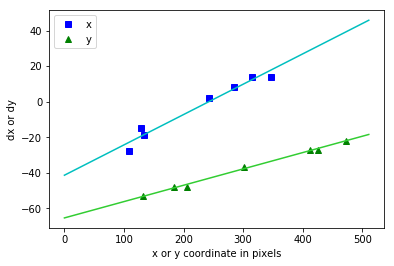

In [49]:
from lmfit.models import LinearModel
x = pts_dot[select][:,0]
y = pts_dot[select][:,1]
dx = points_prism['x'][select]-x
dy = points_prism['y'][select]-y

mod = LinearModel()
pars = mod.guess(dx, x=x)
xresult  = mod.fit(dx, pars, x=x)
pars = mod.guess(dy, x=y)
yresult  = mod.fit(dy, pars, x=y)

plt.plot(x, dx, 'bs', label='x')
plt.plot(y, dy, 'g^', label='y')
plt.plot(xresult.eval(x=np.arange(512)), 'c')
plt.plot(yresult.eval(x=np.arange(512)), 'limegreen')
plt.xlabel('x or y coordinate in pixels')
plt.ylabel('dx or dy')
plt.legend()

In [50]:
print(xresult.best_values)
print(yresult.best_values)

{'slope': 0.17067764250824427, 'intercept': -41.416537529680404}
{'slope': 0.091903239545485613, 'intercept': -65.445929480503409}


## Test parameters on other images

In [51]:
fName1 = 'blue 004-dot.tif'
fName2 = 'blue 004-prism.tif'
tiffimg = tff.TiffFile(fPath+fName1)
image_dot = tiffimg.asarray()
tiffimg = tff.TiffFile(fPath+fName2)
image_prism = tiffimg.asarray()

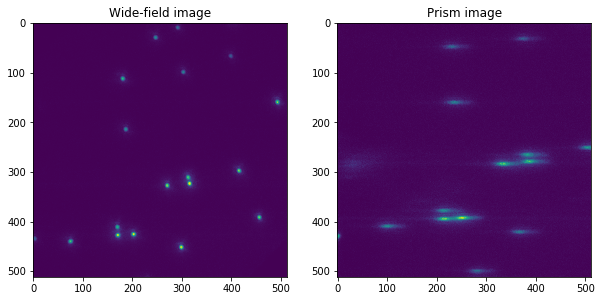

In [52]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(image_dot)
ax[1].imshow(image_prism)
ax[0].set_title('Wide-field image')
ax[1].set_title('Prism image')

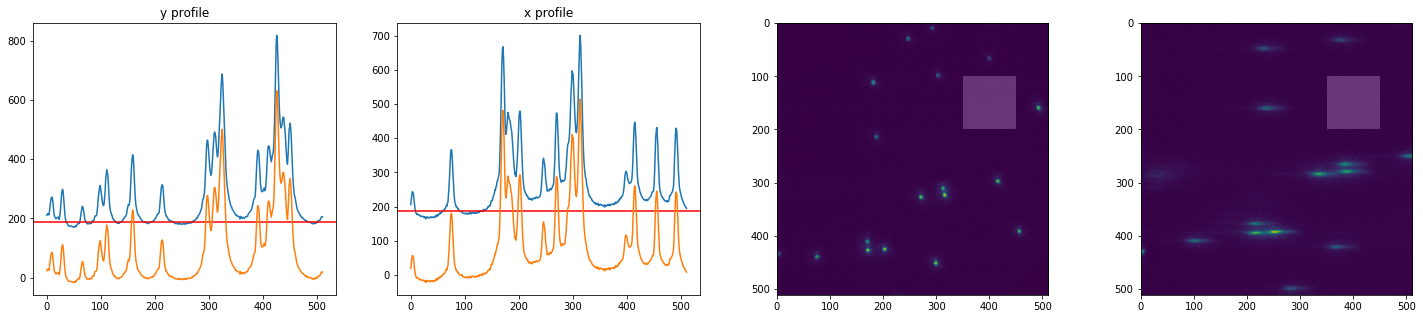

In [53]:
bgroi = (slice(100,200), slice(350,450))
image_dot_bgcr = image_dot - np.mean(image_dot[bgroi])
image_prism_bgcr = image_prism - np.mean(image_prism[bgroi])
mask = np.zeros(image_dot.shape)
mask[bgroi] = 1


fig, ax = plt.subplots(1,4, figsize=(25,5))
ax[0].plot(image_dot.mean(1))
ax[0].axhline(y=image_dot[bgroi].mean(), color='r')
ax[0].plot(image_dot_bgcr.mean(1))
ax[0].set_title('y profile')
ax[1].plot(image_dot.mean(0))
ax[1].axhline(y=image_dot[bgroi].mean(), color='r')
ax[1].plot(image_dot_bgcr.mean(0))
ax[1].set_title('x profile')
ax[2].imshow(image_dot)
ax[3].imshow(image_prism)
ax[2].imshow(mask, alpha=0.2, cmap='gray')
ax[3].imshow(mask, alpha=0.2, cmap='gray')

### find dots

In [54]:
scan = [3,3]
pts_dot = ROI.finddot(image_dot_bgcr, scan, nstd=1.2)
index = []
for i in range(1, len(pts_dot)-1):
    if np.sum((pts_dot[i] - pts_dot[i+1])**2) >= np.sum(np.array(scan)**2):
        if np.sum((pts_dot[i] - pts_dot[i-1])**2) >= np.sum(np.array(scan)**2):
            index = np.append(index, i)
if np.sum((pts_dot[0] - pts_dot[1])**2) >= np.sum(np.array(scan)**2):
    index = np.append(index, 0)
if np.sum((pts_dot[len(pts_dot)-1] - pts_dot[len(pts_dot)-2])**2) >= np.sum(np.array(scan)**2):
    index = np.append(index, len(pts_dot)-1)  
index = np.unique(index).astype('int')
pts_dot = pts_dot[list(index)]

/Users/yungkuo/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yungkuo/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


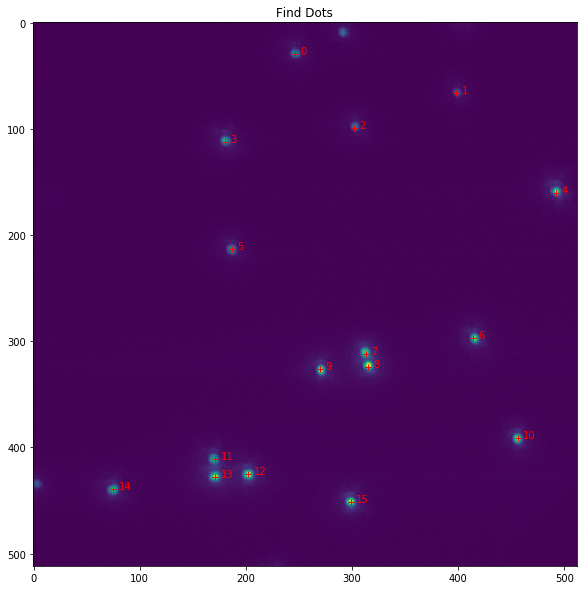

In [55]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Find Dots')
for count, pt in enumerate(pts_dot):
    ax.plot(pt[0],pt[1], 'r+')
    ax.annotate(count, xy=pt+[5,0], color='r')
ax.imshow(image_dot_bgcr, interpolation='None')

In [56]:
dx = xresult.best_values['slope']*pts_dot[:,0] +xresult.best_values['intercept']
dy = yresult.best_values['slope']*pts_dot[:,1] +yresult.best_values['intercept']
points_prism = pd.DataFrame({'x':pts_dot[:,0]+dx, 'y':pts_dot[:,1]+dy}, index=[np.arange(len(pts_dot))])

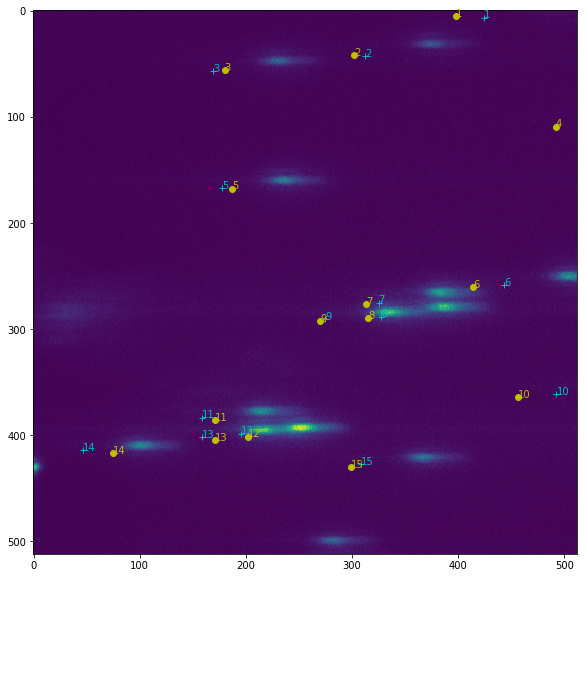

In [57]:
fig, ax = plt.subplots(figsize=(10,10))
for count, pt in enumerate(pts_dot):
    ax.plot(pt[0], (pt[1]+shift)/mag, 'yo')
    ax.annotate(count, xy=[pt[0],(pt[1]+shift)/mag], color='y')
    
    point = (points_prism.loc[count]['x'], points_prism.loc[count]['y'])
    if point[0] > 0 and point[1] > 0:
        ax.plot(point[0], point[1], 'c+')
        ax.annotate(count, xy=(point), color='c')
ax.imshow(image_prism_bgcr)

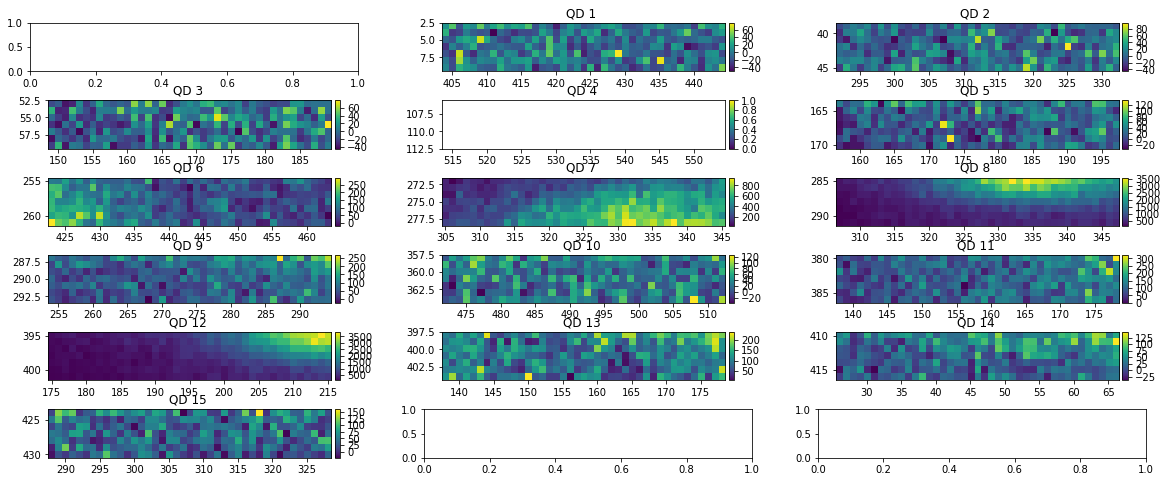

In [58]:
scan = [3,20]
fig, ax = plt.subplots(int(math.ceil(float(len(points_prism))/3)), 3, figsize=(20,math.ceil(float(len(points_prism))/2)))
ax = ax.ravel()
for count, noQD in enumerate(list(points_prism.index)):
    point = (points_prism.loc[noQD]['x'], points_prism.loc[noQD]['y'])
    if point[0] > 0 and point[1] > 0:
        roi = ROI.get_roi_square(point, scan)
        im = ax[count].imshow(image_prism_bgcr[roi], interpolation='none', 
                       extent=(roi[1].start-0.5, roi[1].stop-0.5, roi[0].stop-0.5, roi[0].start-0.5))
        ax[count].set_title('QD {} '.format(noQD))
        divider = make_axes_locatable(ax[count])
        cax = divider.append_axes("right", size="2%", pad=0.05)
        fig.colorbar(im, cax=cax)  
plt.subplots_adjust(hspace = 0.6) 

In [59]:
scan = [3,20]
PP = pd.DataFrame()
for count, noQD in enumerate(list(points_prism.index)):
    point = np.array((points_prism.loc[noQD]['x'], points_prism.loc[noQD]['y']))
    col, row = point.astype('int')
    if col > scan[1] and row > scan[0] and col < 512-scan[1] and row < 512-scan[0]:
        roi = ROI.get_roi_square(point, scan)
        if image_prism_bgcr[row, col] != image_prism_bgcr[roi].max():
            row = np.mean(row-scan[0]+np.where(image_prism_bgcr[roi]==image_prism_bgcr[roi].max())[0])
            col = np.mean(col-scan[1]+np.where(image_prism_bgcr[roi]==image_prism_bgcr[roi].max())[1])
            point = (col,row)
        PP1 = pd.DataFrame({'x':point[0], 'y':point[1]}, index=[count])
        PP = PP.append(PP1)

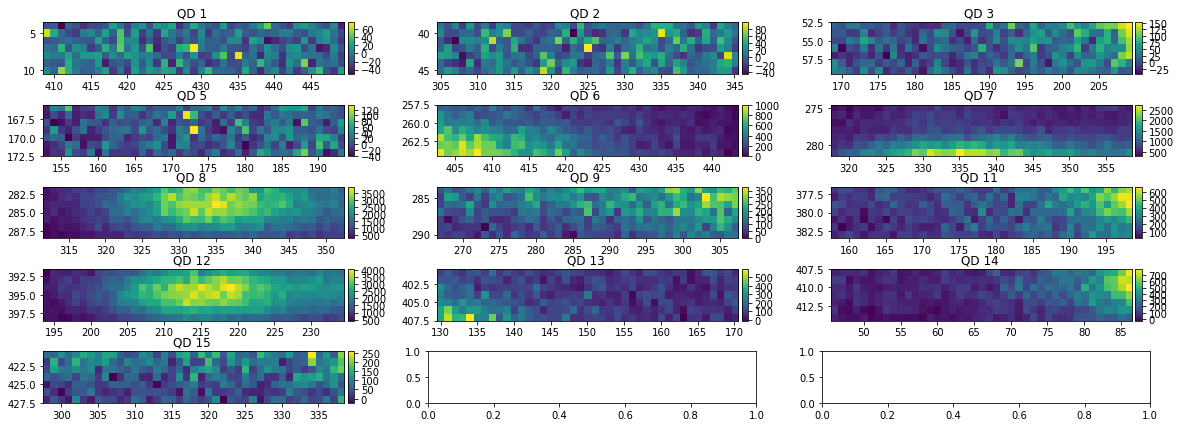

In [60]:
scan = [3,20]
fig, ax = plt.subplots(int(math.ceil(float(len(PP))/3)), 3, figsize=(20,math.ceil(float(len(PP))/2)))
ax = ax.ravel()
for count, noQD in enumerate(list(PP.index)):
    point = (PP.loc[noQD]['x'], PP.loc[noQD]['y'])
    if point[0] > 0 and point[1] > 0:
        roi = ROI.get_roi_square(point, scan)
        im = ax[count].imshow(image_prism_bgcr[roi], interpolation='none', 
                       extent=(roi[1].start-0.5, roi[1].stop-0.5, roi[0].stop-0.5, roi[0].start-0.5))
        ax[count].set_title('QD {} '.format(noQD))
        divider = make_axes_locatable(ax[count])
        cax = divider.append_axes("right", size="2%", pad=0.05)
        fig.colorbar(im, cax=cax)  
plt.subplots_adjust(hspace = 0.6) 

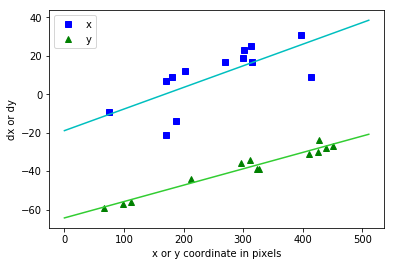

In [62]:
select = list(PP.index)
x = pts_dot[select][:,0]
y = pts_dot[select][:,1]
dx = PP['x']-x
dy = PP['y']-y

mod = LinearModel()
pars = mod.guess(dx, x=x)
xresult  = mod.fit(dx, pars, x=x)
pars = mod.guess(dy, x=y)
yresult  = mod.fit(dy, pars, x=y)

plt.plot(x, dx, 'bs', label='x')
plt.plot(y, dy, 'g^', label='y')
plt.plot(xresult.eval(x=np.arange(512)), 'c')
plt.plot(yresult.eval(x=np.arange(512)), 'limegreen')
plt.xlabel('x or y coordinate in pixels')
plt.ylabel('dx or dy')
plt.legend()

In [29]:
print xresult.best_values
print yresult.best_values

{'slope': 0.11247903910369828, 'intercept': -18.911029866272386}
{'slope': 0.085219414635541502, 'intercept': -64.354720219695182}
